In [1]:
import sys, pandas as pd, numpy as np

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy :", np.__version__)

Python: 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:38:53) [Clang 18.1.8 ]
pandas: 2.3.2
numpy : 2.2.6


In [2]:
from pathlib import Path
import pandas as pd

ROOT = Path("/Users/saitosatoshi/Desktop/motion/case/CSV4")  # ここから下を探索
print("ROOT exists:", ROOT.exists())

# 1) FBTCS/PNES ディレクトリを探索して見つける
cand_fbtcs = sorted([p for p in ROOT.rglob("FBTCS") if p.is_dir()])
cand_pnes  = sorted([p for p in ROOT.rglob("PNES")  if p.is_dir()])

print("\nFound FBTCS dirs:")
for p in cand_fbtcs:
    print(" ", p)

print("\nFound PNES dirs:")
for p in cand_pnes:
    print(" ", p)

if not cand_fbtcs or not cand_pnes:
    raise RuntimeError("FBTCS/PNES フォルダが見つかりません. ROOTやフォルダ名を確認してください.")

# 2) 通常は1つに絞れるはずなので, 先頭を採用
FBTCS_DIR = cand_fbtcs[0]
PNES_DIR  = cand_pnes[0]

print("\nUsing:")
print(" FBTCS_DIR:", FBTCS_DIR)
print(" PNES_DIR :", PNES_DIR)

# 3) CSV一覧
fbtcs_csvs = sorted(FBTCS_DIR.glob("*.csv"))
pnes_csvs  = sorted(PNES_DIR.glob("*.csv"))

print("\n#CSVs")
print(" FBTCS:", len(fbtcs_csvs))
print(" PNES :", len(pnes_csvs))

print("\nSample files (up to 5 each):")
for p in fbtcs_csvs[:5]:
    print("  FBTCS:", p.name)
for p in pnes_csvs[:5]:
    print("  PNES :", p.name)

# 4) カラムチェック関数
def check_columns(csv_paths, group_name, max_show=10):
    print(f"\n=== Column check: {group_name} ===")
    if not csv_paths:
        print("[WARN] No CSV files found.")
        return

    colsets = []
    for i, csv_path in enumerate(csv_paths, start=1):
        try:
            df = pd.read_csv(csv_path, nrows=5)  # 先頭だけで十分
        except Exception as e:
            print(f"[ERROR] {csv_path.name}: {e}")
            continue

        cols = list(df.columns)
        colsets.append(set(cols))

        if i <= max_show:
            print(f"\n{csv_path.name}")
            print(" columns:", cols)

    if not colsets:
        print("[ERROR] No readable CSVs.")
        return

    ref = colsets[0]
    mismatches = 0
    for csv_path, cols in zip(csv_paths, colsets):
        if cols != ref:
            mismatches += 1
            print(f"\n[WARN] Mismatch: {csv_path.name}")
            print("  missing:", sorted(ref - cols))
            print("  extra  :", sorted(cols - ref))

    if mismatches == 0:
        print("\n[OK] All CSVs have identical columns.")

check_columns(pnes_csvs,  "PNES")
check_columns(fbtcs_csvs, "FBTCS")

ROOT exists: True

Found FBTCS dirs:
  /Users/saitosatoshi/Desktop/motion/case/CSV4/FBTCS

Found PNES dirs:
  /Users/saitosatoshi/Desktop/motion/case/CSV4/PNES

Using:
 FBTCS_DIR: /Users/saitosatoshi/Desktop/motion/case/CSV4/FBTCS
 PNES_DIR : /Users/saitosatoshi/Desktop/motion/case/CSV4/PNES

#CSVs
 FBTCS: 27
 PNES : 15

Sample files (up to 5 each):
  FBTCS: AM.csv
  FBTCS: AN.csv
  FBTCS: AS.csv
  FBTCS: AT.csv
  FBTCS: HK.csv
  PNES : AM.csv
  PNES : AM2021.csv
  PNES : AN.csv
  PNES : HO.csv
  PNES : KS.csv

=== Column check: PNES ===

AM.csv
 columns: ['PC1_source', 'Peak_n', 'PC1_mean_0_5', 'PC1_mean_5_10', 'PC1_mean_ratio', 'PC1_area_all', 'PC1_area_0_5', 'PC1_area_5_10', 'PC1_area_ratio', 'ADS_slope_all', 'ADS_R2_all', 'ADS_slope_0_5', 'ADS_slope_5_10', 'Freq_mean_0_5', 'Freq_mean_5_10', 'Freq_ratio', 'Freq_slope_all', 'Kendall_tau_all', 'Kendall_tau_0_5', 'Kendall_tau_5_10', 'IJI_CV_all', 'IJI_CV_0_5', 'IJI_CV_5_10']

AM2021.csv
 columns: ['PC1_source', 'Peak_n', 'PC1_mean_0_5'

In [3]:
# ==========================================================
# Robust summary builder (never empty)
#   - 各CSVの「存在する列だけ」拾う
#   - 欠損は NaN で埋める
# ==========================================================

import pandas as pd
import numpy as np
from pathlib import Path

BASE_DIR = Path("/Users/saitosatoshi/Desktop/motion/case/CSV4")
FBTCS_DIR = BASE_DIR / "FBTCS"
PNES_DIR  = BASE_DIR / "PNES"
OUTPUT_CSV = BASE_DIR / "summary_all.csv"

# 期待する全カラム（あなたが定義した仕様）
ALL_COLS = [
    "Peak_n",
    "PC1_mean_0_5","PC1_mean_5_10","PC1_mean_ratio",
    "PC1_area_all","PC1_area_0_5","PC1_area_5_10","PC1_area_ratio",
    "ADS_slope_all","ADS_R2_all","ADS_slope_0_5","ADS_slope_5_10",
    "Freq_mean_0_5","Freq_mean_5_10","Freq_ratio",
    "Freq_slope_all","Freq_slope_0_5","Freq_slope_5_10",
    "Kendall_tau_all","Kendall_tau_0_5","Kendall_tau_5_10",
    "IJI_CV_all","IJI_CV_0_5","IJI_CV_5_10",
]

def load_group(dir_path: Path, group: str):
    rows = []
    for csv_path in sorted(dir_path.glob("*.csv")):
        df = pd.read_csv(csv_path)

        row = {"group": group, "file": csv_path.name}

        for col in ALL_COLS:
            row[col] = float(df[col].iloc[0]) if col in df.columns else np.nan

        rows.append(row)

    return pd.DataFrame(rows)

df_all = pd.concat(
    [
        load_group(FBTCS_DIR, "FBTCS"),
        load_group(PNES_DIR,  "PNES"),
    ],
    ignore_index=True
)

df_all.to_csv(OUTPUT_CSV, index=False)

print("[OK] summary_all.csv rebuilt")
print("shape:", df_all.shape)
display(df_all.T)

[OK] summary_all.csv rebuilt
shape: (42, 26)


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
group,FBTCS,FBTCS,FBTCS,FBTCS,FBTCS,FBTCS,FBTCS,FBTCS,FBTCS,FBTCS,...,PNES,PNES,PNES,PNES,PNES,PNES,PNES,PNES,PNES,PNES
file,AM.csv,AN.csv,AS.csv,AT.csv,HK.csv,HT.csv,IN.csv,KO.csv,KO2023.csv,KO2024.csv,...,MK.csv,NI.csv,RK.csv,SA.csv,SO.csv,TI.csv,TI2024.csv,YF.csv,YM.csv,YY.csv
Peak_n,15.0,13.0,16.0,21.0,23.0,13.0,17.0,11.0,17.0,16.0,...,12.0,13.0,18.0,19.0,17.0,15.0,20.0,22.0,27.0,19.0
PC1_mean_0_5,0.399492,0.334848,0.716363,0.616733,0.460235,0.582253,0.699238,0.45446,0.527686,0.861361,...,0.25292,0.092172,0.029474,0.02011,0.104085,0.138307,0.145135,0.071774,0.075478,0.363986
PC1_mean_5_10,0.52558,0.200057,0.461815,0.583413,0.500658,0.3197,0.418807,0.212204,0.478492,0.923259,...,0.232624,0.061703,0.027317,0.025546,0.071882,0.08273,0.124943,0.111409,0.094528,0.423789
PC1_mean_ratio,1.315621,0.597456,0.644666,0.945974,1.087831,0.549074,0.598947,0.466937,0.906774,1.071861,...,0.919754,0.669436,0.926797,1.270302,0.690603,0.598162,0.860873,1.552217,1.252387,1.164302
PC1_area_all,4.60541,2.66396,5.882032,5.994535,4.799597,4.511796,5.597057,3.322057,5.024454,8.928829,...,2.432667,0.771725,0.283389,0.228119,0.881856,1.105578,1.348621,0.915771,0.847942,3.928829
PC1_area_0_5,1.988948,1.670203,3.575846,3.080003,2.302505,2.911842,3.502585,2.269131,2.632397,4.307374,...,1.269501,0.462823,0.147291,0.100692,0.522278,0.692886,0.720527,0.359616,0.376606,1.813383
PC1_area_5_10,2.605679,0.986685,2.293841,2.882265,2.492188,1.57581,2.091101,1.052154,2.363087,4.585633,...,1.161955,0.307176,0.135807,0.126124,0.357362,0.411505,0.621138,0.555736,0.470669,2.104098
PC1_area_ratio,1.310079,0.590757,0.641482,0.935799,1.082381,0.541173,0.597017,0.463681,0.897694,1.064601,...,0.915285,0.6637,0.922026,1.25257,0.684238,0.593899,0.86206,1.545359,1.249765,1.160317


group
FBTCS    27
PNES     15
Name: count, dtype: int64


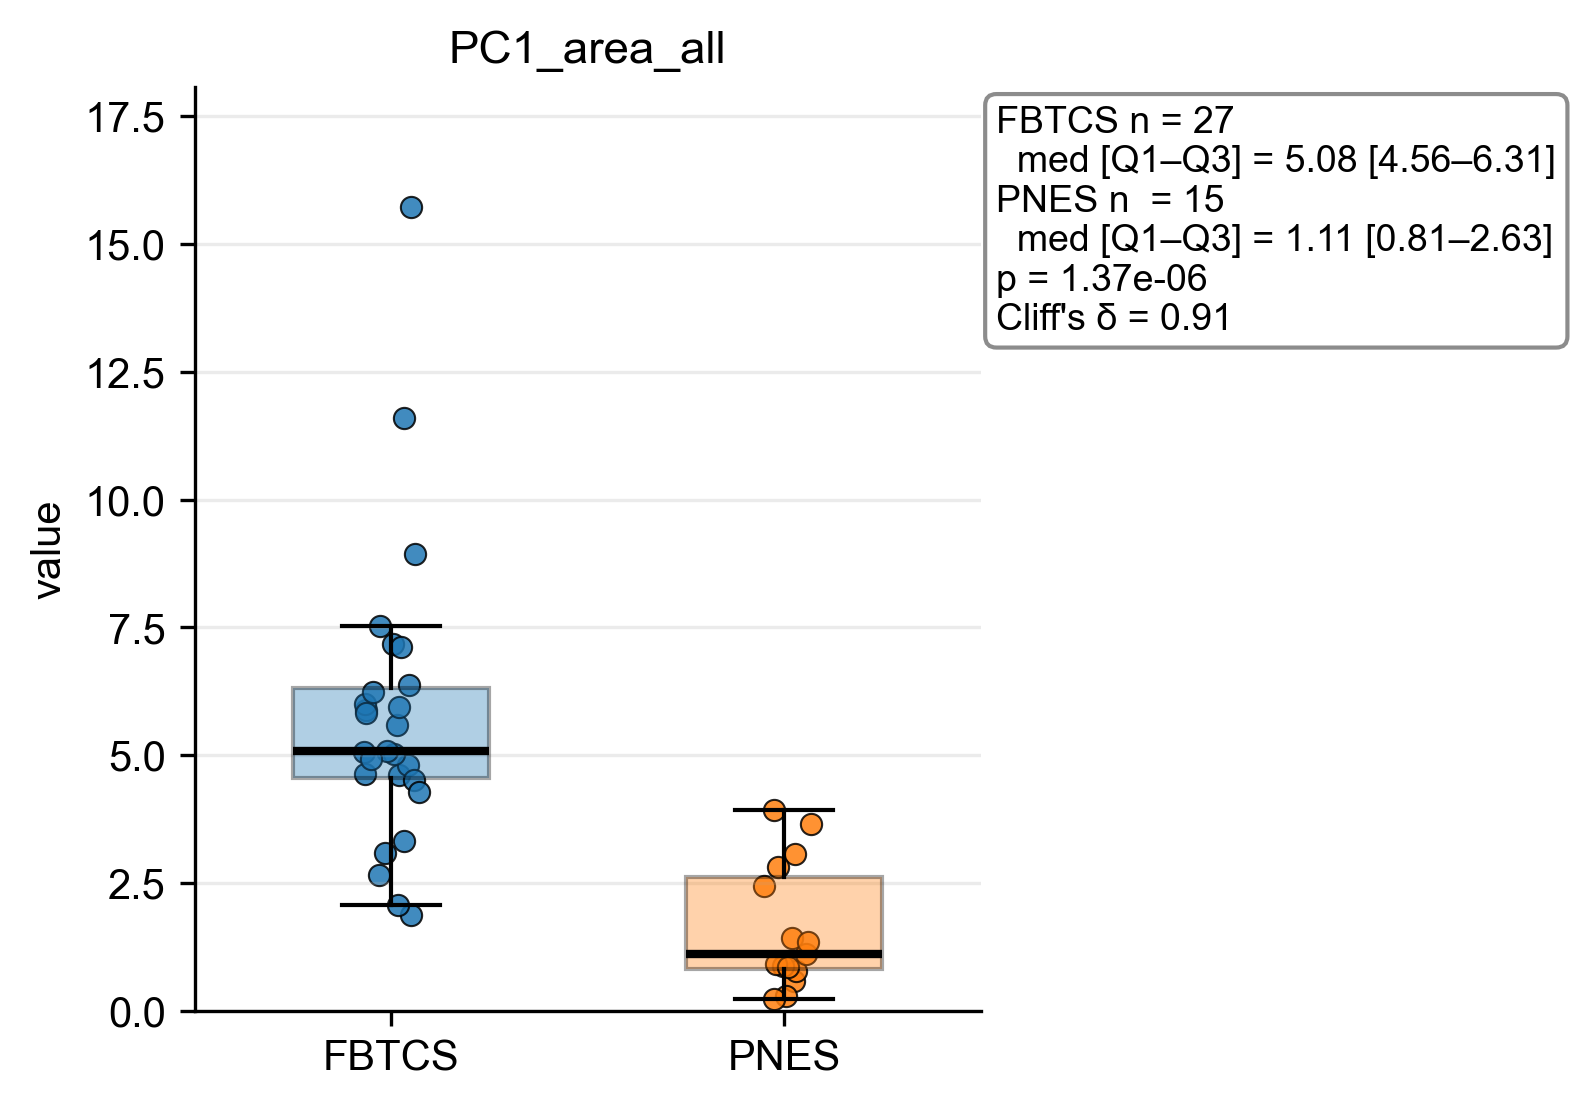

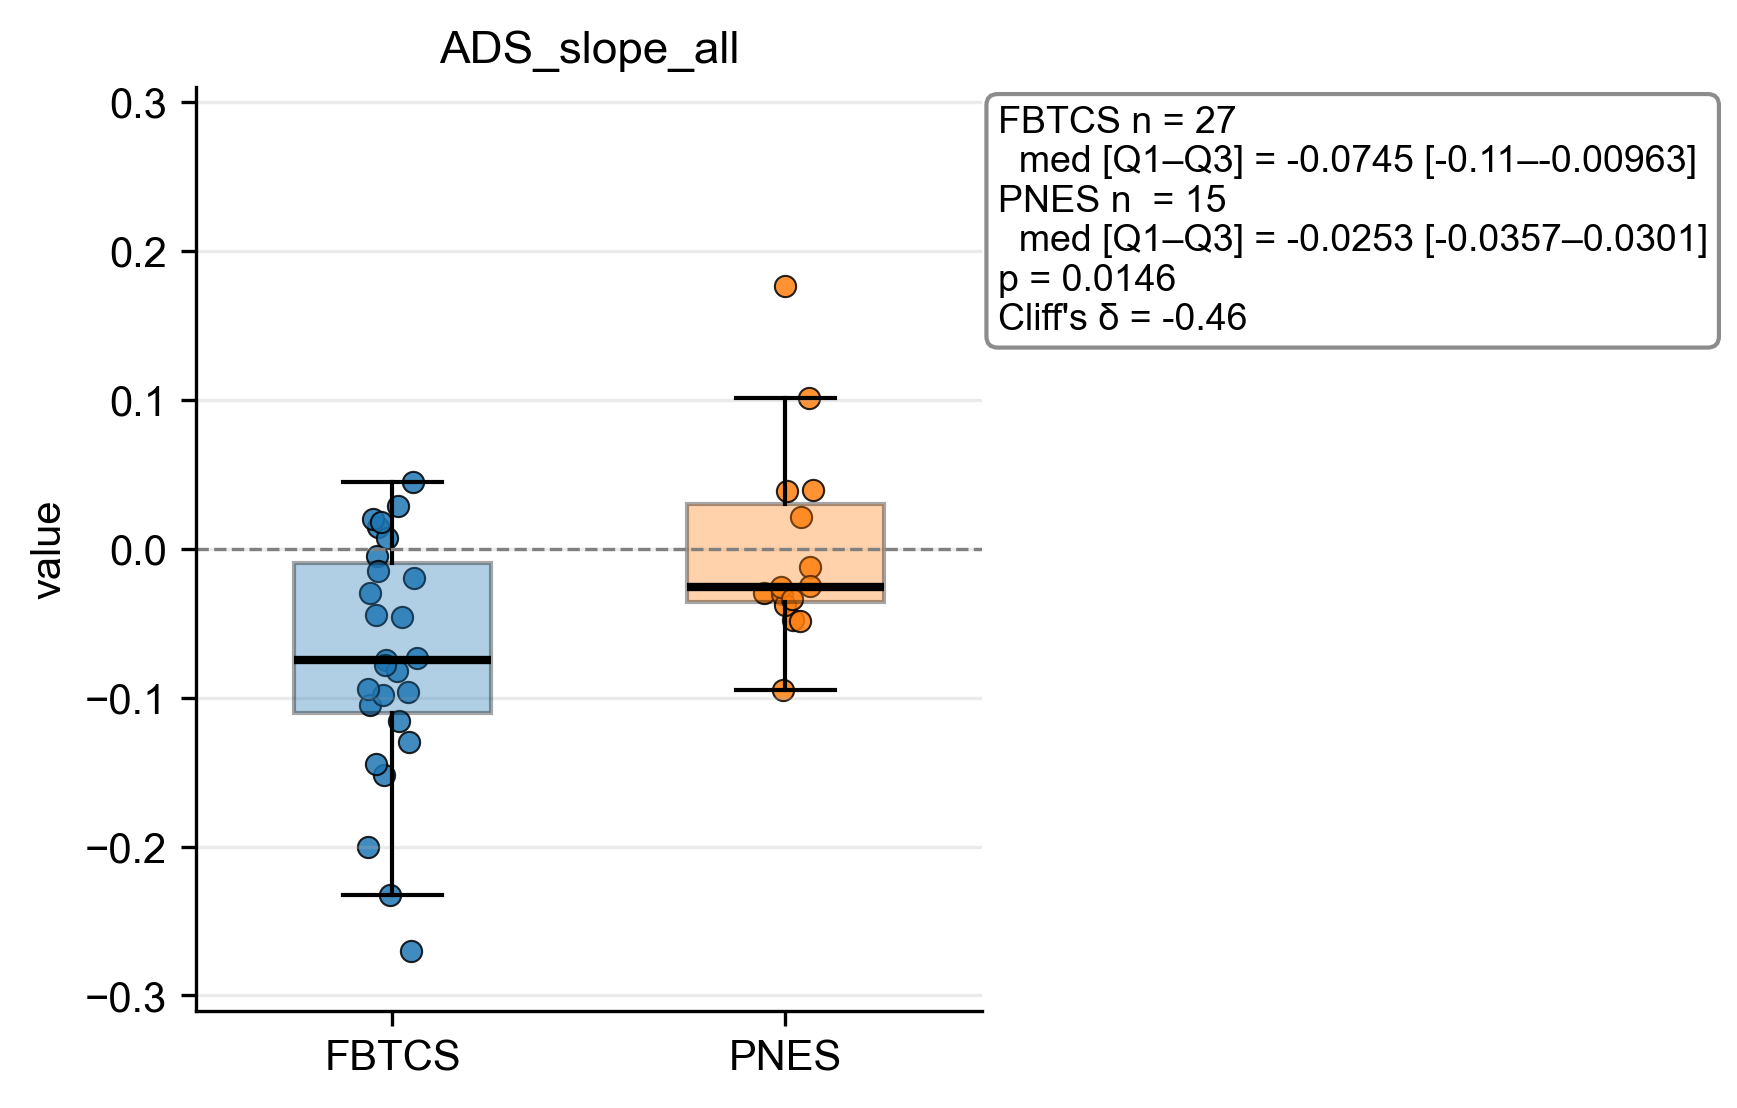

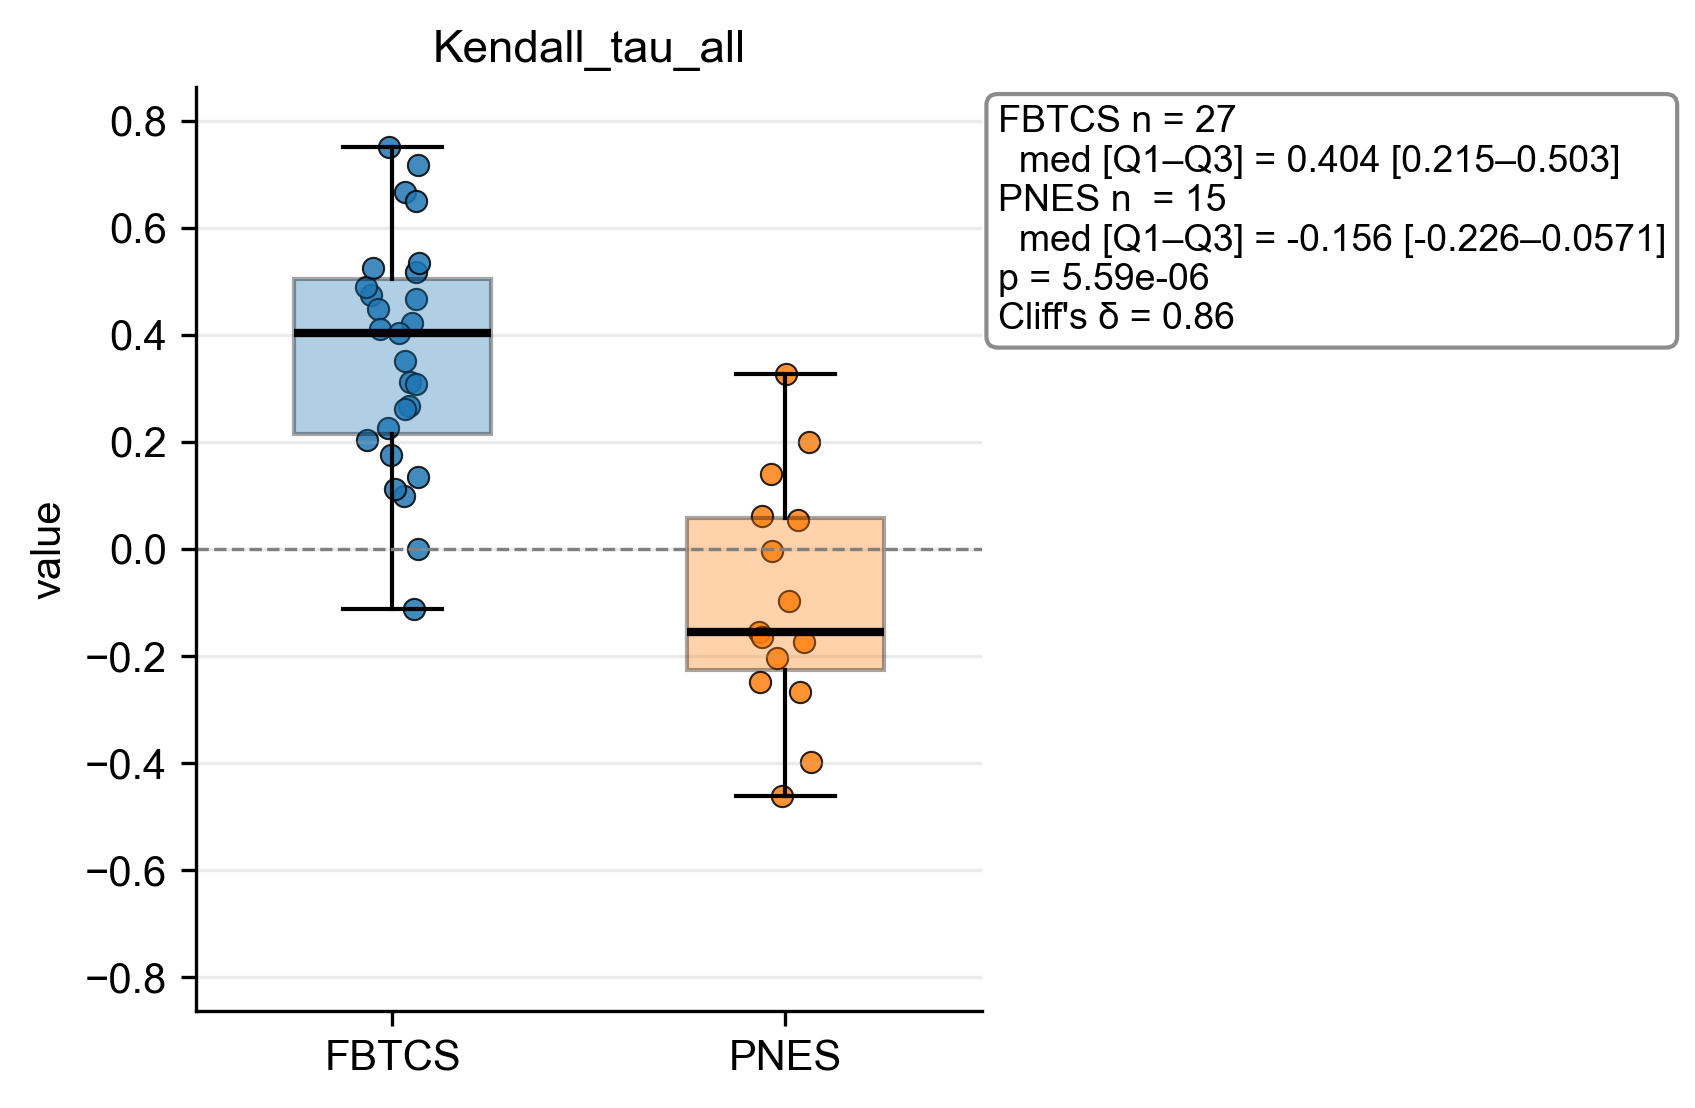

,metric,FBTCS_n,PNES_n,p_value,cliffs_delta
0,PC1_area_all,27,15,0.000001,0.911111
1,ADS_slope_all,27,15,0.014637,-0.461728
2,Kendall_tau_all,27,15,0.000006,0.856790


[OK] saved figures to: /Users/saitosatoshi/Desktop/motion/case/CSV4/fig_boxplots


In [4]:
# ==========================================================
# Boxplots (1 metric per figure), Arial-like font,
# stats labels outside axes, save each at dpi=300.
# ==========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from pathlib import Path

BASE_DIR = Path("/Users/saitosatoshi/Desktop/motion/case/CSV4")
in_csv   = BASE_DIR / "summary_all.csv"          # ファイル名は実物に合わせて
out_dir  = BASE_DIR / "fig_boxplots"
out_dir.mkdir(parents=True, exist_ok=True)

df_all = pd.read_csv(in_csv)

df_all["group"] = df_all["group"].astype(str).str.strip()
print(df_all["group"].value_counts())

# 以下, あなたの boxplot ループは同じでOK
# out_png = os.path.join(out_dir, ...) のところだけ str(out_dir) を使うか Pathで書く


# -------------------------
# フォント設定, Arialが無ければ近いものにフォールバック
# 例, ColabやLinuxでは Arial が無いことが多いので
# Liberation Sans, DejaVu Sans を候補に入れます.
# -------------------------
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial", "Liberation Sans", "DejaVu Sans"]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"]  = 42

# -------------------------
# 効果量（Cliff's delta）
# -------------------------
def cliffs_delta(x, y):
    """
    Cliff's delta, 非パラメトリックな効果量.
    xとyの全ペア比較で, x>y と x<y の差を正規化する.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0:
        return np.nan

    gt = sum(xi > yj for xi in x for yj in y)
    lt = sum(xi < yj for xi in x for yj in y)
    return (gt - lt) / (nx * ny)


def median_iqr(a):
    """
    配列aの中央値と四分位(Q1, Q3)を返す.
    NaNは除外してから計算する.
    """
    a = np.asarray(a)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return np.nan, np.nan, np.nan

    q1 = np.percentile(a, 25)
    med = np.percentile(a, 50)
    q3 = np.percentile(a, 75)
    return med, q1, q3
# -------------------------
# 比較する指標
# -------------------------
ALL_COLUMNS = ["PC1_area_all", "ADS_slope_all", "Kendall_tau_all"]

# -------------------------
# 事前チェック
# -------------------------
missing = [c for c in ALL_COLUMNS if c not in df_all.columns]
if missing:
    print("[WARN] summary に存在しない列:", missing)

use_cols = [c for c in ALL_COLUMNS if c in df_all.columns]

# -------------------------
# 図の共通パラメータ
# -------------------------
SAVE_DPI = 300
FIG_W, FIG_H = 4, 4   # 1枚あたりのサイズ, 論文図向けに控えめ
RIGHT_MARGIN = 0.78       # 右に統計ラベル用スペースを作る(0-1)

# -------------------------
# 乱数, jitter用
# -------------------------
rng = np.random.default_rng(0)
jitter = 0.07

stats_records = []

for col in use_cols:
    # ---- データ抽出
    x = df_all.loc[df_all["group"] == "FBTCS", col].dropna().values
    y = df_all.loc[df_all["group"] == "PNES",  col].dropna().values

    # ---- 図を1枚作る
    fig, ax = plt.subplots(figsize=(FIG_W, FIG_H), dpi=SAVE_DPI)

    # ---- データ不足
    if len(x) < 2 or len(y) < 2:
        ax.text(
            0.5, 0.5, "n < 2",
            transform=ax.transAxes,
            ha="center", va="center", fontsize=11
        )
        ax.set_title(col)
        ax.axis("off")

        stats_records.append({
            "metric": col,
            "FBTCS_n": len(x),
            "PNES_n": len(y),
            "p_value": np.nan,
            "cliffs_delta": np.nan
        })

        # 保存, 右余白も含めて保存
        fig.subplots_adjust(right=RIGHT_MARGIN)
        out_png = os.path.join(out_dir, f"box_{col}.png")
        fig.savefig(out_png, dpi=SAVE_DPI, bbox_inches="tight")
        plt.close(fig)
        continue

    # ---- 統計
    _, p = mannwhitneyu(x, y, alternative="two-sided")
    delta = cliffs_delta(x, y)

    # ---- 中央値と四分位
    med_x, q1_x, q3_x = median_iqr(x)
    med_y, q1_y, q3_y = median_iqr(y)

    # ---- boxplot
    bp = ax.boxplot(
        [x, y],
        positions=[1, 2],
        widths=0.5,
        showfliers=False,
        patch_artist=True,
        medianprops=dict(color="black", linewidth=2)
    )

    # 色, 指定しない方針でも良いですが,
    # 既存コードの意図を尊重して薄色にしています.
    for patch, c in zip(bp["boxes"], ["tab:blue", "tab:orange"]):
        patch.set_facecolor(c)
        patch.set_alpha(0.35)

    # ---- strip plot
    ax.scatter(
        1 + rng.uniform(-jitter, jitter, len(x)),
        x, s=26, alpha=0.85, edgecolor="k", linewidth=0.5
    )
    ax.scatter(
        2 + rng.uniform(-jitter, jitter, len(y)),
        y, s=26, alpha=0.85, edgecolor="k", linewidth=0.5
    )

    # ---- y軸レンジ
    v = np.concatenate([x, y])

    if col == "PC1_area_all":
        # PC1_areaは |PC1| のAUCなので 0以上が自然
        vmax = np.nanmax(v)
        if np.isfinite(vmax) and vmax > 0:
            ax.set_ylim(0, 1.15 * vmax)
        else:
            ax.set_ylim(0, 1)

        # 0中心線は不要(常に0以上なので)
        # ax.axhline(0, color="gray", lw=0.8, ls="--")

    else:
        # ADS_slopeやKendall_tauは正負あり得るので 0中心
        m = np.nanmax(np.abs(v))
        if np.isfinite(m) and m > 0:
            ax.set_ylim(-1.15 * m, 1.15 * m)
        ax.axhline(0, color="gray", lw=0.8, ls="--")

    ax.set_xticks([1, 2])
    ax.set_xticklabels(["FBTCS", "PNES"])
    ax.set_title(col, fontsize=11)
    ax.set_ylabel("value")

    # ---- 見た目
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, axis="y", alpha=0.25)

    # ==========================================================
    # 統計ラベルを plot の外(右側)へ
    # 重要, x座標を 1.02 にして axes の外へ出す.
    # そのために右余白を fig.subplots_adjust(right=...) で確保する.
    # ==========================================================
    stat_text = (
        f"FBTCS n = {len(x)}\n"
        f"  med [Q1–Q3] = {med_x:.3g} [{q1_x:.3g}–{q3_x:.3g}]\n"
        f"PNES n  = {len(y)}\n"
        f"  med [Q1–Q3] = {med_y:.3g} [{q1_y:.3g}–{q3_y:.3g}]\n"
        f"p = {p:.3g}\n"
        f"Cliff's δ = {delta:.2f}"
    )

    ax.text(
        1.02, 0.98,
        stat_text,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=9,
        bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.90)
    )

    # ---- 右余白を確保して保存
    fig.subplots_adjust(right=RIGHT_MARGIN)

    out_png = os.path.join(out_dir, f"box_{col}.png")
    fig.savefig(out_png, dpi=SAVE_DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    stats_records.append({
        "metric": col,
        "FBTCS_n": len(x),
        "PNES_n": len(y),
        "p_value": p,
        "cliffs_delta": delta
    })

# -------------------------
# 統計サマリー
# -------------------------
df_stats = pd.DataFrame(stats_records)
display(df_stats)

# 必要ならCSV保存
# df_stats.to_csv(os.path.join(out_dir, "boxplot_stats.csv"), index=False)

print("[OK] saved figures to:", out_dir)

group
FBTCS    27
PNES     15
Name: count, dtype: int64
saved: /Users/saitosatoshi/Desktop/motion/case/CSV4/fig_scatter/scatter_ADS_vs_tau.png


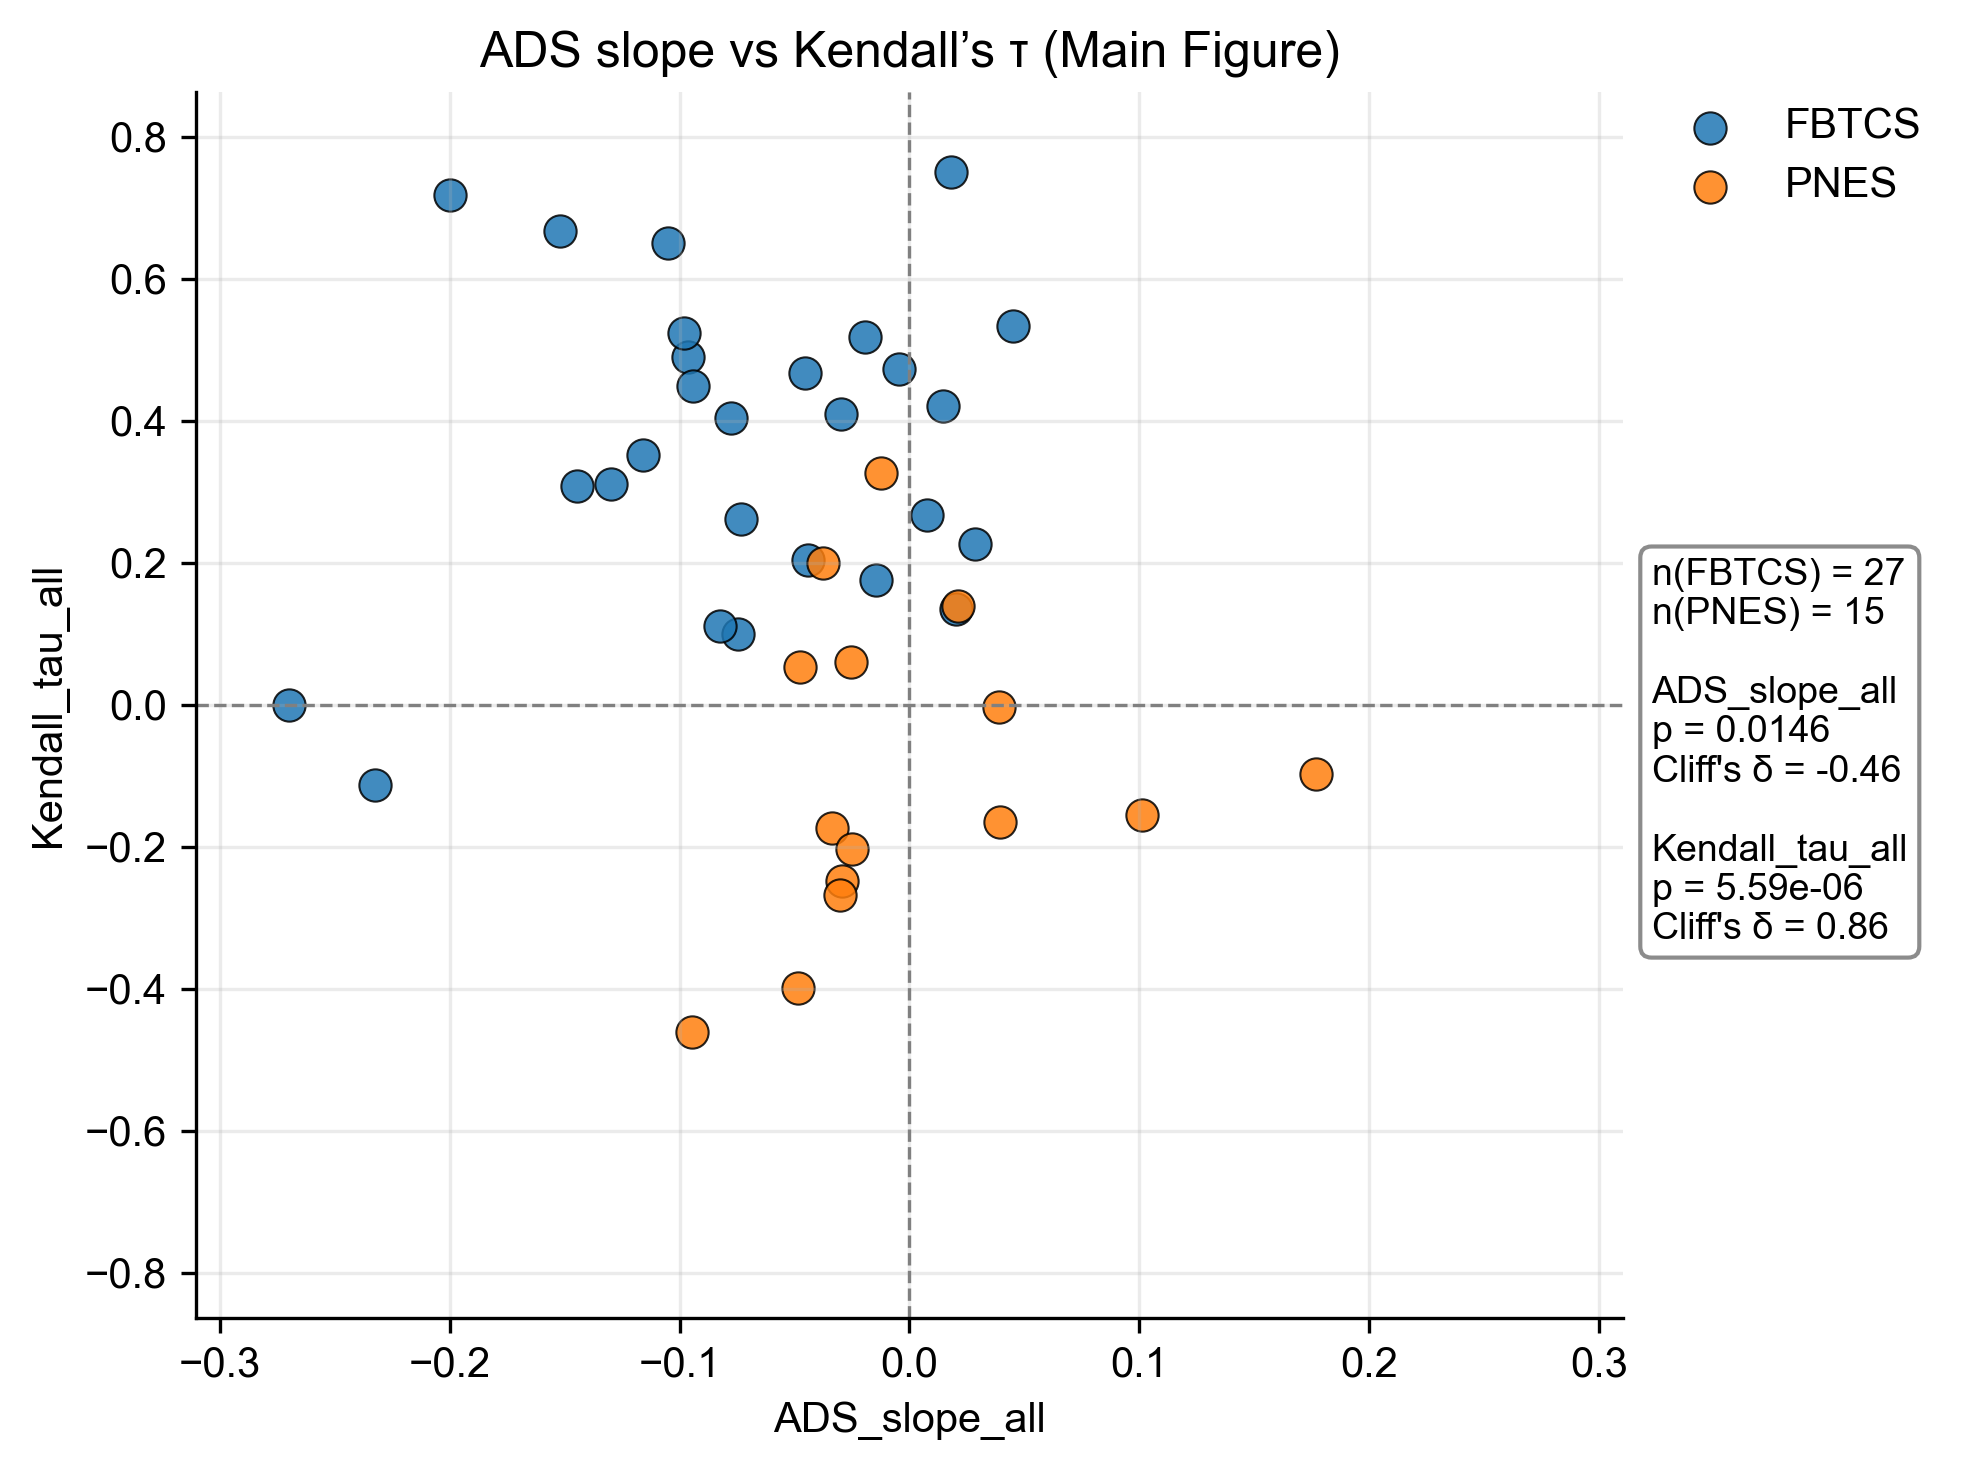

saved: /Users/saitosatoshi/Desktop/motion/case/CSV4/fig_scatter/scatter_tau_vs_PC1area.png


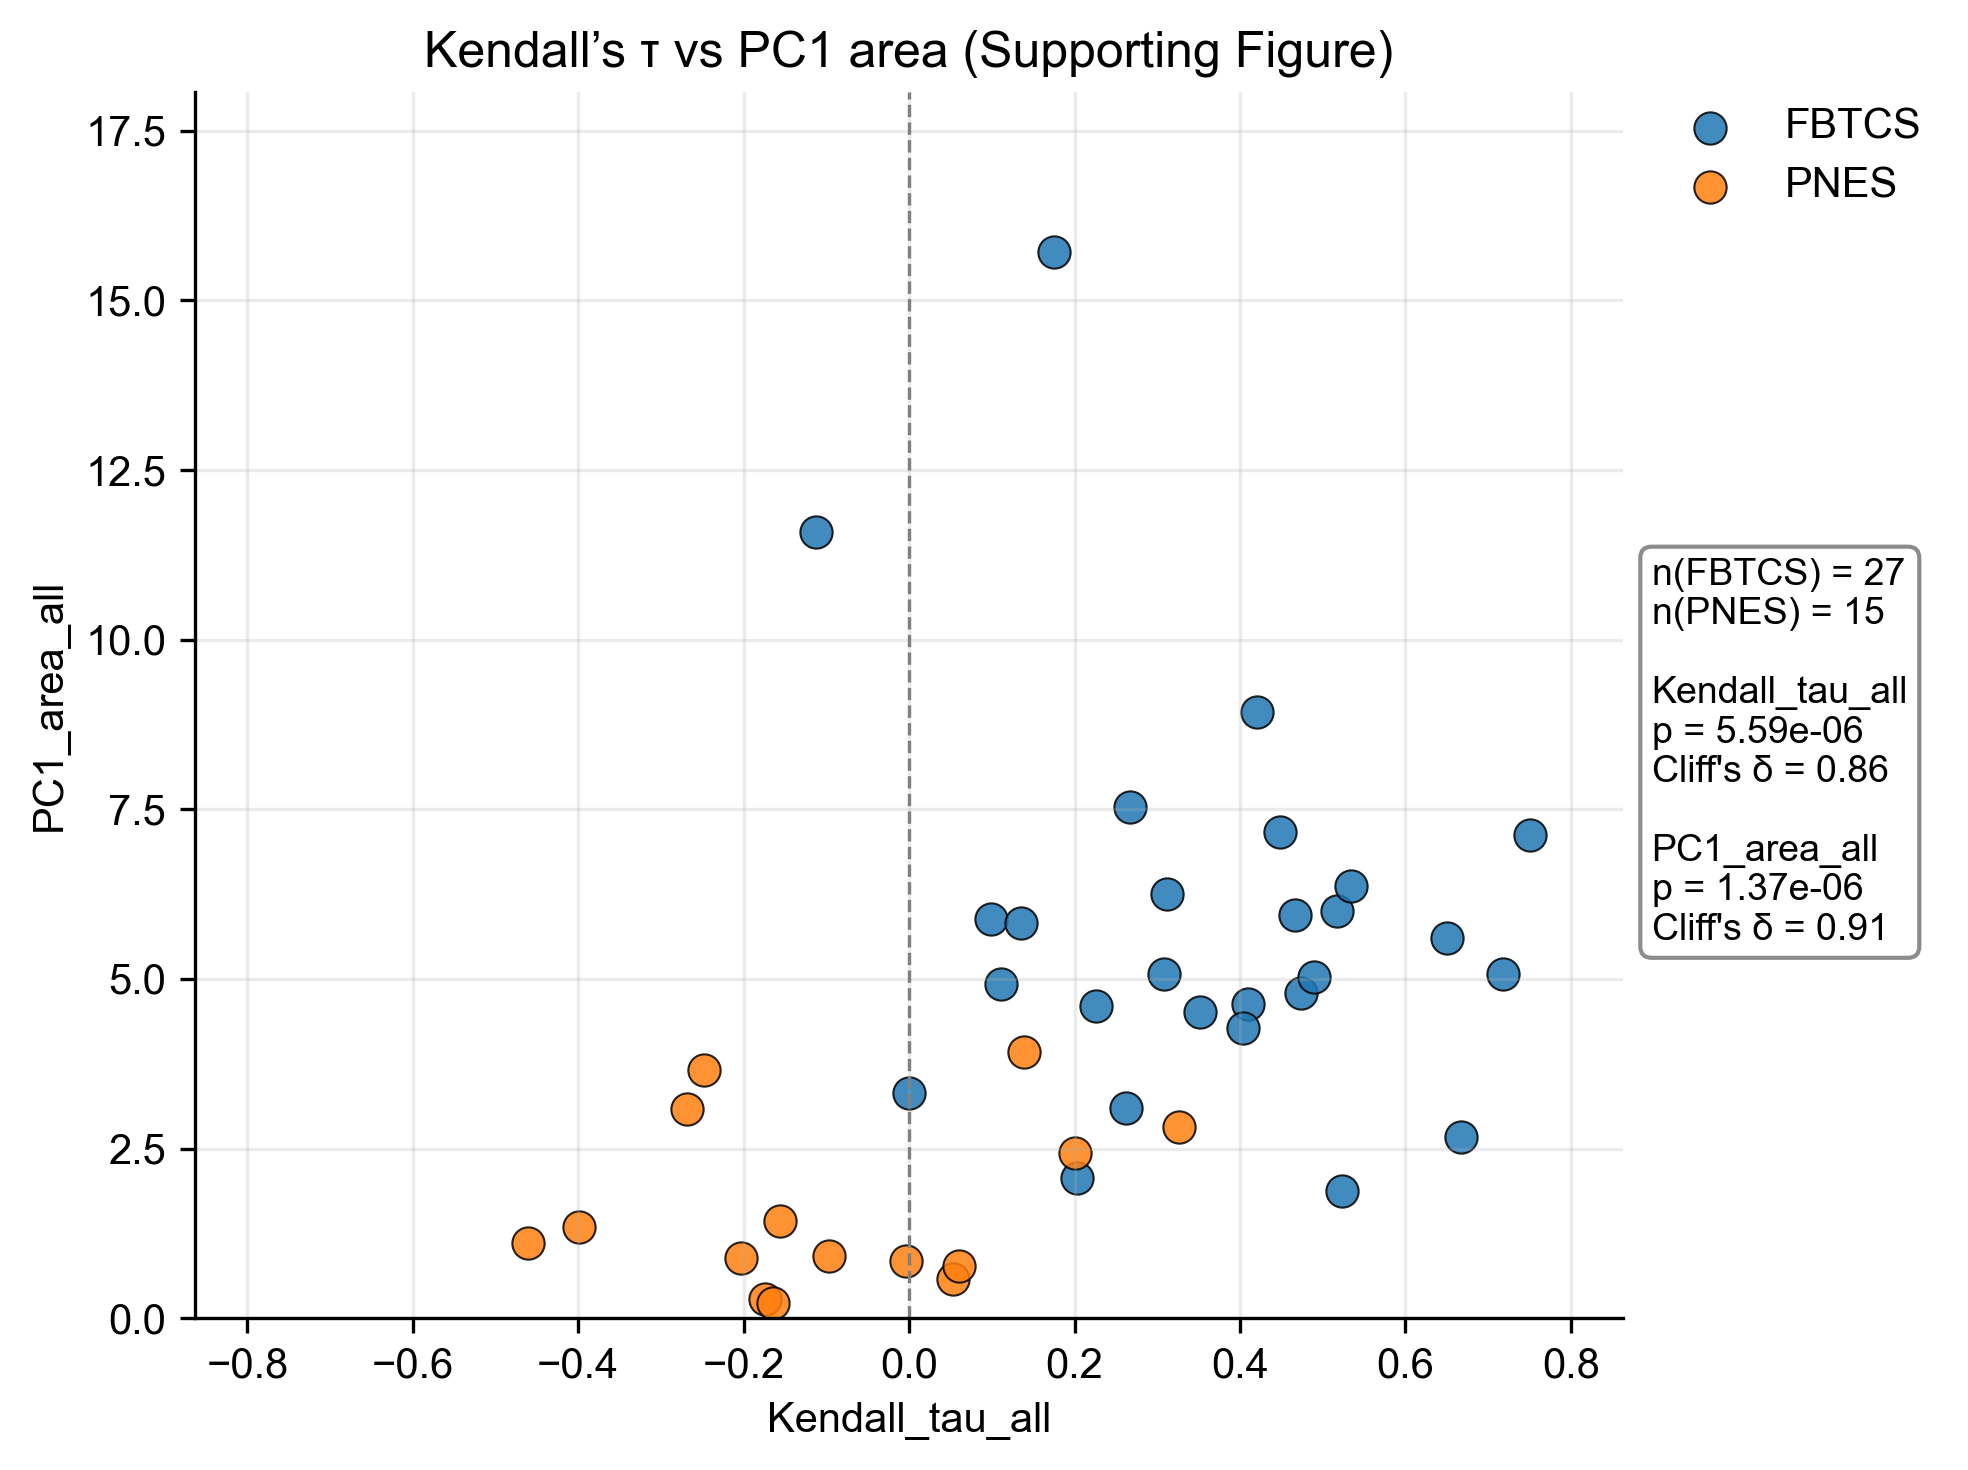

saved: /Users/saitosatoshi/Desktop/motion/case/CSV4/fig_scatter/scatter_ADS_vs_PC1area.png


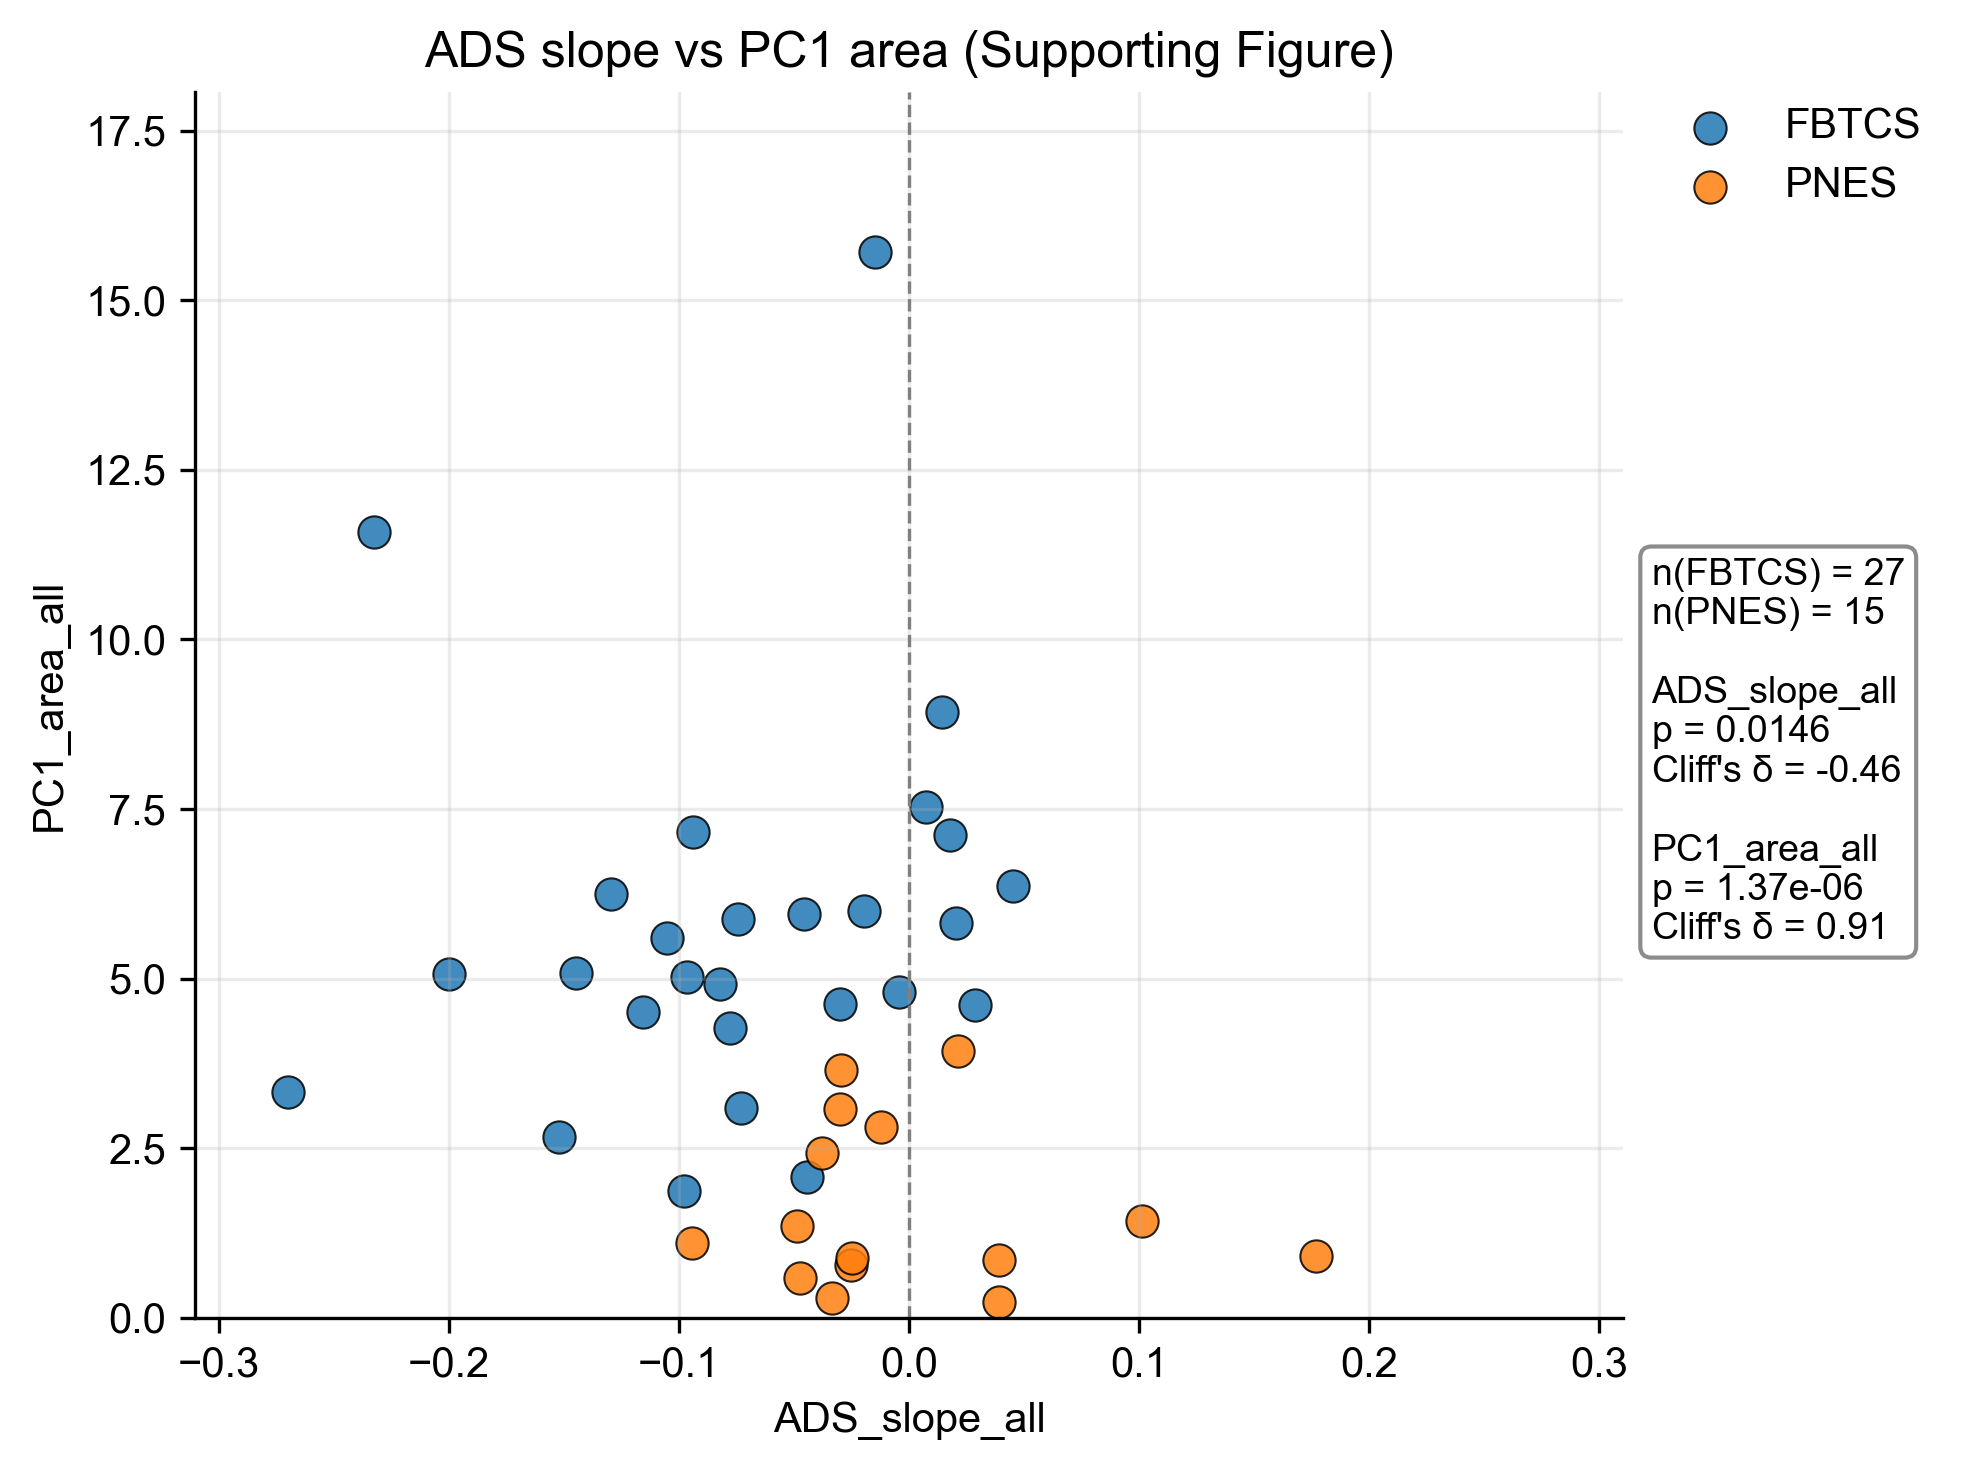

saved: /Users/saitosatoshi/Desktop/motion/case/CSV4/fig_scatter/scatter_3D.png


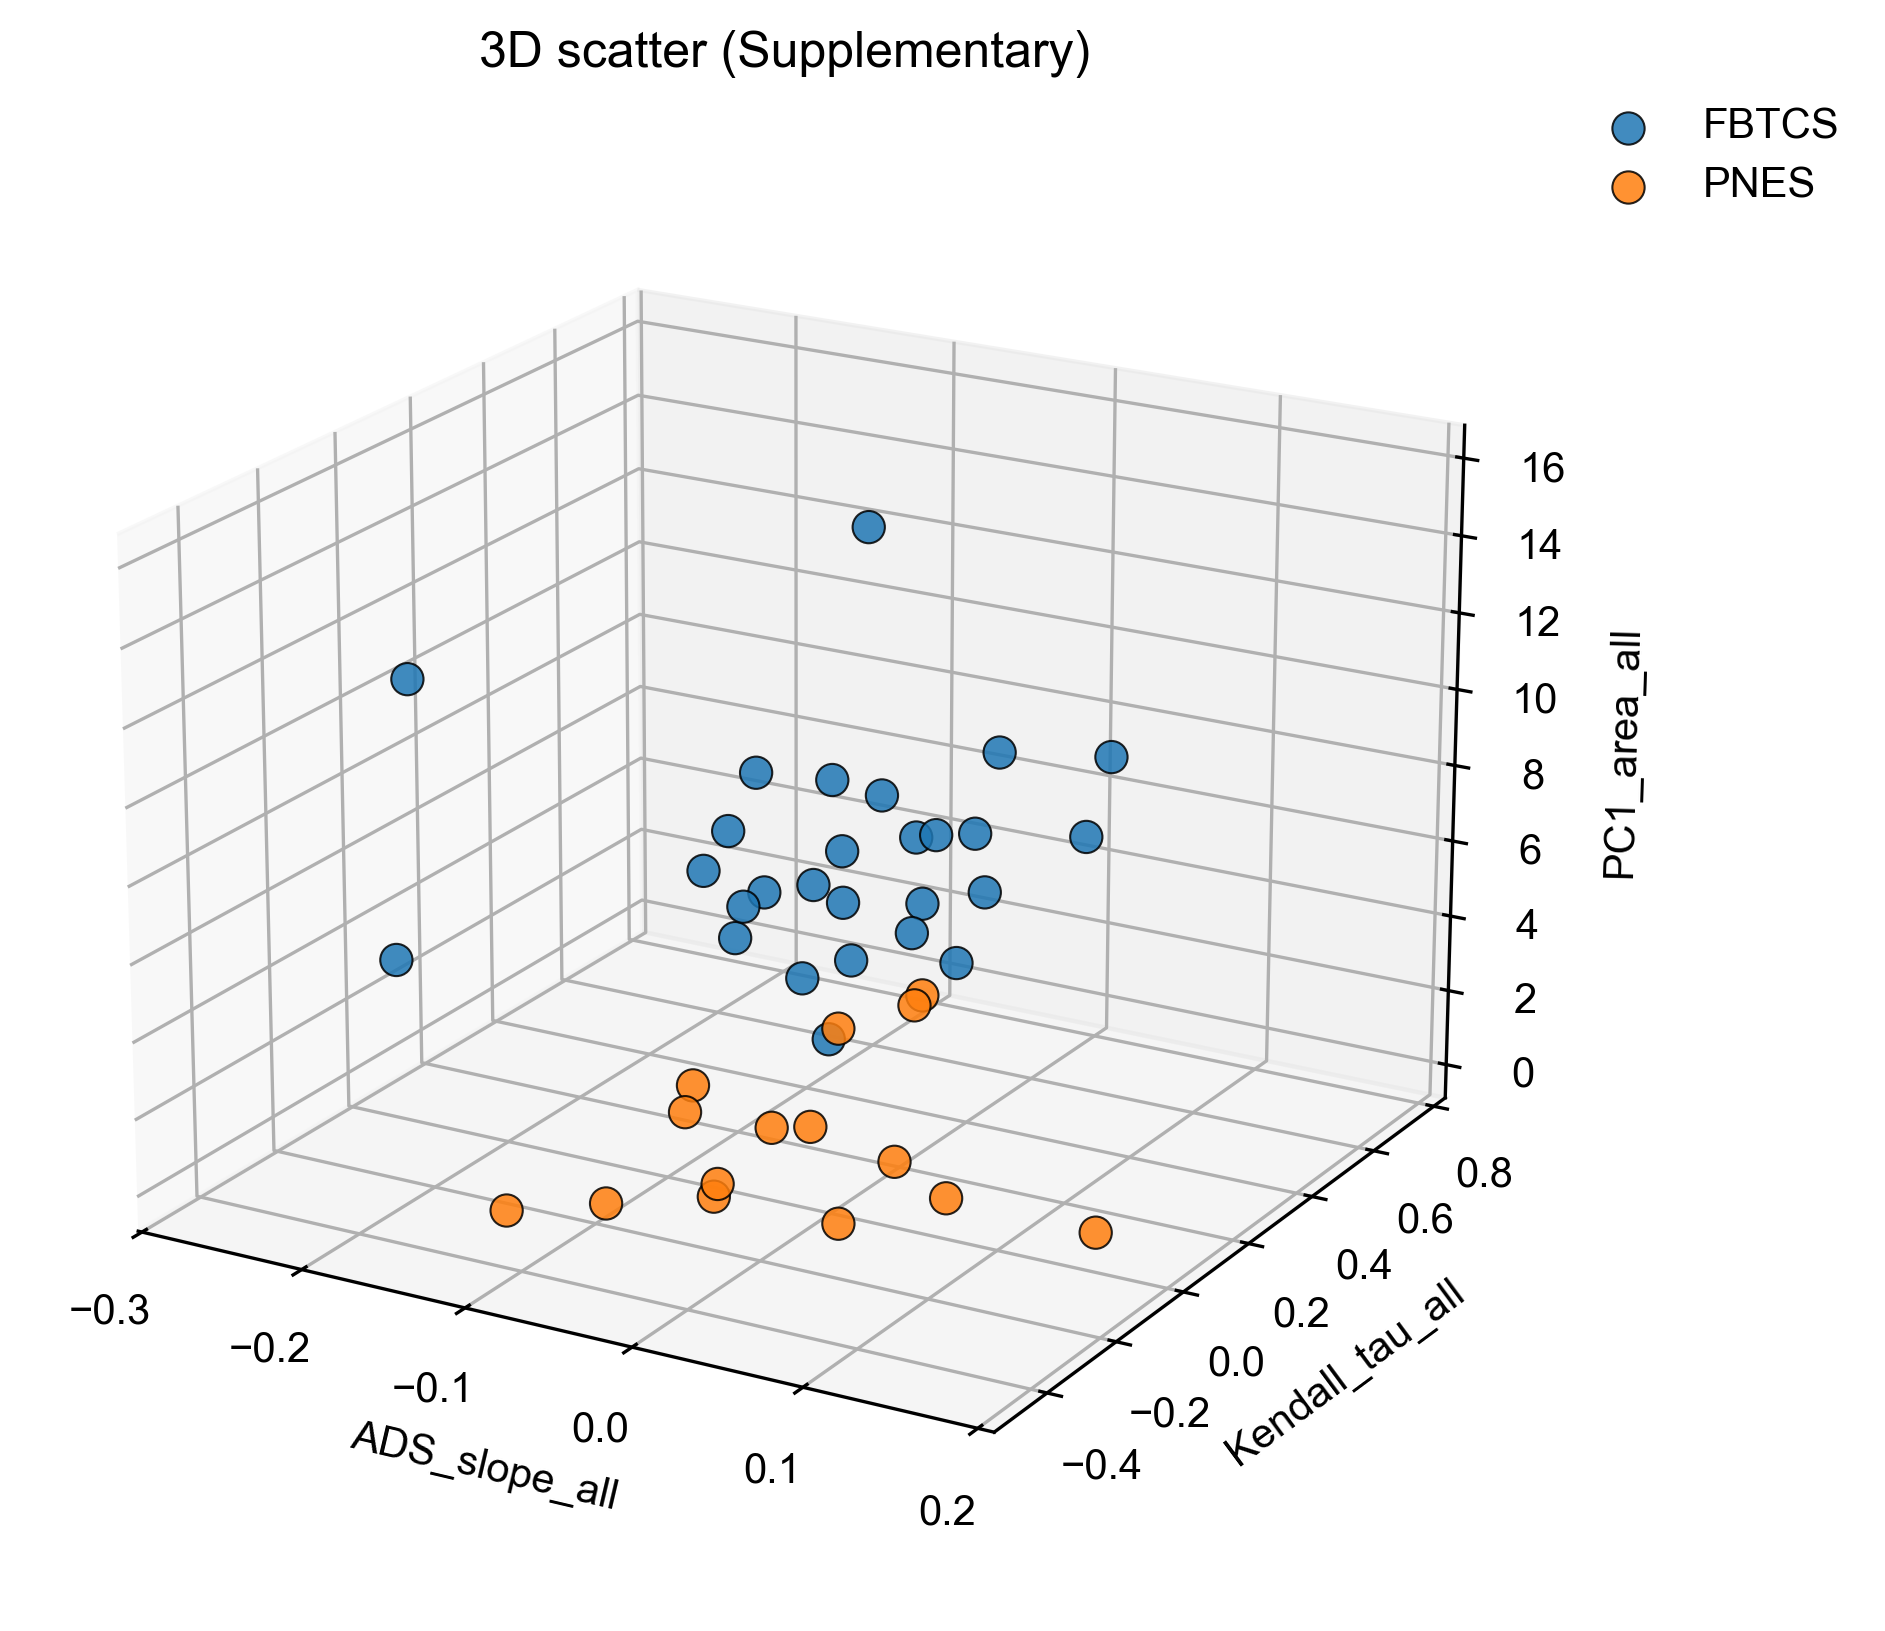

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from mpl_toolkits.mplot3d import Axes3D  # noqa
from pathlib import Path

BASE_DIR = Path("/Users/saitosatoshi/Desktop/motion/case/CSV4")

# =========================
# 入力
# =========================
in_csv = BASE_DIR / "summary_all.csv"  # 実ファイル名に合わせて
df_all = pd.read_csv(in_csv)

# =========================
# 出力
# =========================
out_dir = str(BASE_DIR / "fig_scatter")
os.makedirs(out_dir, exist_ok=True)

SAVE_DPI = 300
RIGHT_MARGIN = 0.78
FIGSIZE_2D = (7, 5)
FIGSIZE_3D = (7.0, 8.0)

# フォント設定（環境によってはArialが無いのでDejaVu Sansに落ちます）
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial", "Liberation Sans", "DejaVu Sans"]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

# =========================
# group列の前処理
# =========================
GROUP_COL = "group"
df_all[GROUP_COL] = df_all[GROUP_COL].astype(str).str.strip()
print(df_all[GROUP_COL].value_counts())

# この2群がある前提
GROUP_A = "FBTCS"
GROUP_B = "PNES"

COLORS = {
    GROUP_A: "tab:blue",
    GROUP_B: "tab:orange",
}
MARKERS = {
    GROUP_A: "o",
    GROUP_B: "o",
}

# ==========================================================
# 効果量（Cliff's delta）
# ==========================================================
def cliffs_delta(x, y):
    """
    Cliff's delta, 非パラメトリックな効果量.
    xとyの全ペア比較で, x>y と x<y の差を正規化する.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0:
        return np.nan

    # 注意, ここはO(nx*ny)なので, 症例数が多いと重くなります.
    gt = sum(xi > yj for xi in x for yj in y)
    lt = sum(xi < yj for xi in x for yj in y)
    return (gt - lt) / (nx * ny)

def mw_stats(x_a, x_b):
    """
    Mann–Whitney U と Cliff's delta を返す.
    データ不足なら NaN.
    """
    x_a = np.asarray(x_a)
    x_b = np.asarray(x_b)
    if len(x_a) < 2 or len(x_b) < 2:
        return np.nan, np.nan

    _, p = mannwhitneyu(x_a, x_b, alternative="two-sided")
    d = cliffs_delta(x_a, x_b)
    return p, d

def symmetric_limits(ax, v, setter, pad=1.15):
    """
    値vから原点対称の表示範囲を作る.
    padを大きくすると余白が増えます.
    """
    v = np.asarray(v)
    v = v[np.isfinite(v)]
    if len(v) == 0:
        return

    m = np.max(np.abs(v))
    if np.isfinite(m) and m > 0:
        setter(-pad * m, pad * m)

def scatter_2d_outside(ax, df, xcol, ycol, title, stat_y=0.62, lim_pad=1.15):
    """
    2次元散布図.
    凡例と統計ラベルを plot の外(右側)に出す.
    統計は x軸, y軸それぞれで GROUP_A vs GROUP_B を比較して表示する.

    stat_y, 統計ボックスの縦位置（axes座標）.
    lim_pad, x,yの原点対称limの余白倍率.
    """
    # ---- scatter
    for g in [GROUP_A, GROUP_B]:
        d = df[df[GROUP_COL] == g]
        ax.scatter(
            d[xcol],
            d[ycol],
            s=60,
            alpha=0.85,
            edgecolor="k",
            linewidth=0.5,
            label=g,
            color=COLORS[g],
            marker=MARKERS[g],
        )

    # ---- limits (原点対称)
    symmetric_limits(ax, df[xcol].values, ax.set_xlim, pad=lim_pad)
    symmetric_limits(ax, df[ycol].values, ax.set_ylim, pad=lim_pad)

    ax.axhline(0, color="gray", lw=0.8, ls="--")
    ax.axvline(0, color="gray", lw=0.8, ls="--")

    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.set_title(title)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.25)

    # ---- legend outside
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.0,
        frameon=False,
    )

    # ---- stats outside
    xa = df.loc[df[GROUP_COL] == GROUP_A, xcol].dropna().values
    xb = df.loc[df[GROUP_COL] == GROUP_B, xcol].dropna().values
    ya = df.loc[df[GROUP_COL] == GROUP_A, ycol].dropna().values
    yb = df.loc[df[GROUP_COL] == GROUP_B, ycol].dropna().values

    px, dx = mw_stats(xa, xb)
    py, dy = mw_stats(ya, yb)

    stat_text = (
        f"n({GROUP_A}) = {len(xa)}\n"
        f"n({GROUP_B}) = {len(xb)}\n\n"
        f"{xcol}\n"
        f"p = {px:.3g}\n"
        f"Cliff's δ = {dx:.2f}\n\n"
        f"{ycol}\n"
        f"p = {py:.3g}\n"
        f"Cliff's δ = {dy:.2f}"
    )

    ax.text(
        1.02, stat_y,
        stat_text,
        transform=ax.transAxes,
        ha="left",
        va="top",
        fontsize=9,
        bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.90),
    )

def save_fig(fig, filename, right_margin=RIGHT_MARGIN):
    """
    dpi=300で保存. 外側ラベルも切れないようにする.
    right_marginを図ごとに変えたい場合に対応.
    """
    fig.subplots_adjust(right=right_margin)
    out_path = os.path.join(out_dir, filename)
    fig.savefig(out_path, dpi=SAVE_DPI, bbox_inches="tight")
    print("saved:", out_path)

# ==========================================================
# 2D scatter, 1枚目（個別に微調整できるブロック）
# ==========================================================
xcol_1 = "ADS_slope_all"
ycol_1 = "Kendall_tau_all"
title_1 = "ADS slope vs Kendall’s τ (Main Figure)"
fname_1 = "scatter_ADS_vs_tau.png"

fig, ax = plt.subplots(figsize=FIGSIZE_2D, dpi=SAVE_DPI)

# この図だけ, 統計ボックスの位置やlim余白を変えられる
scatter_2d_outside(
    ax,
    df_all,
    xcol=xcol_1,
    ycol=ycol_1,
    title=title_1,
    stat_y=0.62,
    lim_pad=1.15,
)

fig.tight_layout()
save_fig(fig, fname_1, right_margin=RIGHT_MARGIN)
plt.show()
plt.close(fig)

# ==========================================================
# 2D scatter, 2枚目（y軸 = area, y>=0）
# ==========================================================
xcol_2 = "Kendall_tau_all"
ycol_2 = "PC1_area_all"
title_2 = "Kendall’s τ vs PC1 area (Supporting Figure)"
fname_2 = "scatter_tau_vs_PC1area.png"

fig, ax = plt.subplots(figsize=FIGSIZE_2D, dpi=SAVE_DPI)

scatter_2d_outside(
    ax,
    df_all,
    xcol=xcol_2,
    ycol=ycol_2,
    title=title_2,
    stat_y=0.62,
    lim_pad=1.15,   # x軸（tau）は今まで通り
)

# ---- y軸は area 専用設定（0以上）
yvals = df_all[ycol_2].dropna().values
ymax = np.max(yvals) * 1.15
ax.set_ylim(0, ymax)

# y=0 の破線は不要なので消す
for line in ax.lines:
    if np.allclose(line.get_ydata(), 0):
        line.remove()

fig.tight_layout()
save_fig(fig, fname_2, right_margin=RIGHT_MARGIN)
plt.show()
plt.close(fig)

# ==========================================================
# 2D scatter, 3枚目（y軸 = area, y>=0）
# ==========================================================
xcol_3 = "ADS_slope_all"
ycol_3 = "PC1_area_all"
title_3 = "ADS slope vs PC1 area (Supporting Figure)"
fname_3 = "scatter_ADS_vs_PC1area.png"

fig, ax = plt.subplots(figsize=FIGSIZE_2D, dpi=SAVE_DPI)

scatter_2d_outside(
    ax,
    df_all,
    xcol=xcol_3,
    ycol=ycol_3,
    title=title_3,
    stat_y=0.62,
    lim_pad=1.15,   # x軸（ADS）は原点対称のまま
)

# ---- y軸は area 専用設定（0以上）
yvals = df_all[ycol_3].dropna().values
ymax = np.max(yvals) * 1.15
ax.set_ylim(0, ymax)

# y=0 の破線を消す
for line in ax.lines:
    if np.allclose(line.get_ydata(), 0):
        line.remove()

fig.tight_layout()
save_fig(fig, fname_3, right_margin=RIGHT_MARGIN)
plt.show()
plt.close(fig)

# ==========================================================
# 3D scatter（これは元々1枚なのでそのまま）
# ==========================================================
fig = plt.figure(figsize=FIGSIZE_3D, dpi=SAVE_DPI)
ax = fig.add_subplot(111, projection="3d")

for g in [GROUP_A, GROUP_B]:
    d = df_all[df_all[GROUP_COL] == g]
    ax.scatter(
        d["ADS_slope_all"],
        d["Kendall_tau_all"],
        d["PC1_area_all"],
        s=60,
        alpha=0.85,
        edgecolor="k",
        linewidth=0.5,
        label=g,
        color=COLORS[g],
        marker=MARKERS[g],
    )

ax.set_xlabel("ADS_slope_all")
ax.set_ylabel("Kendall_tau_all")
ax.set_zlabel("PC1_area_all")
ax.set_title("3D scatter (Supplementary)")

ax.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0,
    frameon=False,
)

ax.view_init(elev=20, azim=-60)

fig.tight_layout()
fig.subplots_adjust(right=0.74)  # 3Dは余白を広めに
out_path = os.path.join(out_dir, "scatter_3D.png")
fig.savefig(out_path, dpi=SAVE_DPI, bbox_inches="tight")
print("saved:", out_path)
plt.show()
plt.close(fig)